## Setup

In [6]:
import sys, os
sys.path.insert(0, os.path.abspath(os.path.join('..', 'src')))

In [7]:
import concurrent.futures
import json
from pathlib import Path
import time
from pprint import pprint

import matplotlib.pyplot as plt
import sklearn.datasets
import sklearn.metrics
import sklearn.model_selection

import autosklearn.classification

from AutoSklearn.with_ensemble import with_ensemble_experiment
from AutoSklearn.without_ensemble import without_ensemble_experiment

## Dataset and Experiments Parameters

In [ ]:
dataset_name = 'iris'

X, y = sklearn.datasets.fetch_openml(
    name=dataset_name,
    version=1,
    return_X_y=True,
    as_frame=True
)
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
    X, y, random_state=1
)

tmp_path = Path('../results/tmp') / dataset_name
time_limit = 60 * 1  # 60 * número de minutos

## Experiments Functions

In [9]:
start_time = time.time()

results = {}

def process_result(experiment_name, automl_model):
    """Processa o resultado quando a thread termina"""
    print(f"{experiment_name} concluído!")
    
    predictions = automl_model.predict(X_test)
    accuracy = sklearn.metrics.accuracy_score(y_test, predictions)
    
    results[experiment_name] = {
        'model': automl_model,
        'accuracy': accuracy,
        'predictions': predictions
    }

with concurrent.futures.ThreadPoolExecutor(max_workers=2) as executor:
    print("Iniciando experimento COM ensemble...")
    future_with = executor.submit(
        with_ensemble_experiment, 
        X_train, y_train, time_limit, dataset_name, tmp_path / 'with_ensemble'
    )
    
    print("Iniciando experimento SEM ensemble...")
    future_without = executor.submit(
        without_ensemble_experiment, 
        X_train, y_train, time_limit, dataset_name, tmp_path / 'without_ensemble'
    )
    
    for future in concurrent.futures.as_completed([future_with, future_without]):
        if future == future_with:
            automl_with_ensemble = future.result()
            process_result("COM ensemble", automl_with_ensemble)
        else:
            automl_without_ensemble = future.result()
            process_result("SEM ensemble", automl_without_ensemble)

Iniciando experimento COM ensemble...
Iniciando experimento SEM ensemble...


/home/joao/miniconda3/envs/as-env/lib/python3.9/site-packages/autosklearn/data/target_validator.py:187: UserWarning: Fitting transformer with a pandas series which has the dtype category. Inverse transform may not be able preserve dtype when converting to np.ndarray
  warnings.warn(
/home/joao/miniconda3/envs/as-env/lib/python3.9/site-packages/autosklearn/data/target_validator.py:187: UserWarning: Fitting transformer with a pandas series which has the dtype category. Inverse transform may not be able preserve dtype when converting to np.ndarray
  warnings.warn(


[WARNING] [2025-07-19 16:53:24,373:smac.runhistory.runhistory2epm.RunHistory2EPM4LogCost] Got cost of smaller/equal to 0. Replace by 0.000010 since we use log cost.
[WARNING] [2025-07-19 16:53:25,628:smac.runhistory.runhistory2epm.RunHistory2EPM4LogCost] Got cost of smaller/equal to 0. Replace by 0.000010 since we use log cost.
[WARNING] [2025-07-19 16:53:28,295:smac.runhistory.runhistory2epm.RunHistory2EPM4LogCost] Got cost of smaller/equal to 0. Replace by 0.000010 since we use log cost.
[WARNING] [2025-07-19 16:53:30,970:smac.runhistory.runhistory2epm.RunHistory2EPM4LogCost] Got cost of smaller/equal to 0. Replace by 0.000010 since we use log cost.
[WARNING] [2025-07-19 16:53:33,575:smac.runhistory.runhistory2epm.RunHistory2EPM4LogCost] Got cost of smaller/equal to 0. Replace by 0.000010 since we use log cost.
[WARNING] [2025-07-19 16:53:36,445:smac.runhistory.runhistory2epm.RunHistory2EPM4LogCost] Got cost of smaller/equal to 0. Replace by 0.000010 since we use log cost.
[WARNING] 

In [12]:
total_time = time.time() - start_time
print(f"Todos os experimentos concluídos em {total_time:.2f} segundos")

Todos os experimentos concluídos em 464.83 segundos


SEM ensemble: acurácia = 0.9737
COM ensemble: acurácia = 0.9737

### SEM ensemble - leaderboard
          rank  ensemble_weight        type  cost  duration
model_id                                                   
28           1              1.0  libsvm_svc   0.0  0.803859

### COM ensemble - leaderboard
          rank  ensemble_weight                 type      cost  duration
model_id                                                                
7            1             0.04        random_forest  0.000000  1.278858
41           4             0.04    gradient_boosting  0.000000  1.141298
48           5             0.02           libsvm_svc  0.000000  0.778843
65           2             0.06           libsvm_svc  0.000000  0.703574
82           3             0.02           libsvm_svc  0.000000  0.812882
8           16             0.02                  mlp  0.027027  1.085432
55          11             0.06          gaussian_nb  0.027027  0.835991
56          10             0.04    

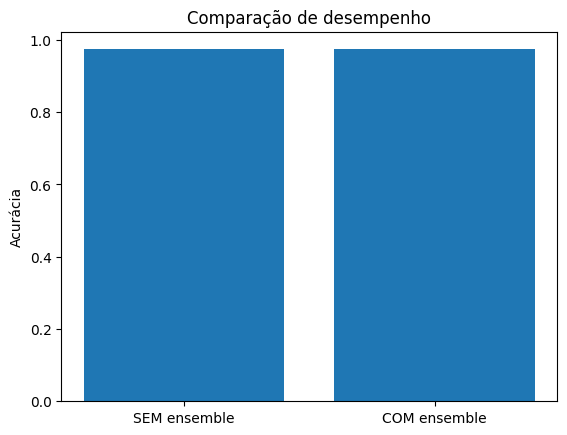

/home/joao/miniconda3/envs/as-env/lib/python3.9/site-packages/autosklearn/automl.py:1860: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  pd.merge(
/home/joao/miniconda3/envs/as-env/lib/python3.9/site-packages/autosklearn/automl.py:1860: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  pd.merge(


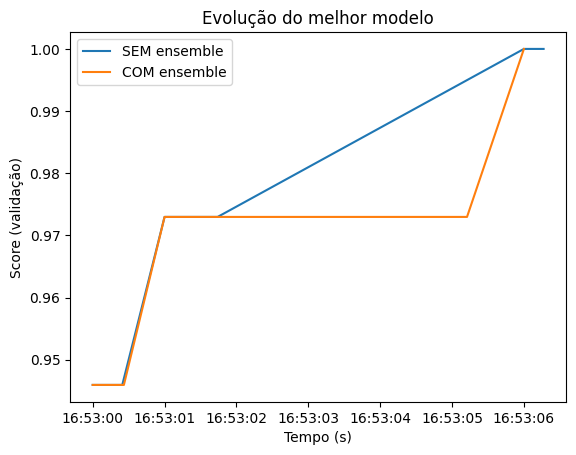

In [18]:
# --- métricas numéricas ---
for label, info in results.items():
    print(f"{label}: acurácia = {info['accuracy']:.4f}")

# --- leaderboard de cada modelo ---
for label, info in results.items():
    print(f"\n### {label} - leaderboard")
    print(info['model'].leaderboard())

# --- gráfico de acurácia ---
labels = list(results.keys())
scores = [info['accuracy'] for info in results.values()]

plt.figure()
plt.bar(labels, scores)
plt.ylabel('Acurácia')
plt.title('Comparação de desempenho')
plt.show()

# --- curva de performance ao longo do tempo ---
plt.figure()
for label, info in results.items():
    df = info['model'].performance_over_time_
    plt.plot(df['Timestamp'], df['single_best_optimization_score'], label=label)

plt.xlabel('Tempo (s)')
plt.ylabel('Score (validação)')
plt.legend()
plt.title('Evolução do melhor modelo')
plt.show()

In [17]:
from pprint import pprint

def safe_params(obj):
    if hasattr(obj, "get_params"):
        try:
            return obj.get_params(deep=False)
        except Exception:
            return {}
    return {}

def describe_pipeline(pipeline):
    for name, step in pipeline.steps:
        real_step = step.choice if hasattr(step, "choice") else step
        print(f"{name}: {real_step.__class__.__name__}")
        params = safe_params(real_step)
        if params:
            pprint(params, depth=2)
        else:
            print("  (sem hiper‑parâmetros expostos)")

for label, info in results.items():
    print(f"\n### {label}")
    for weight, pipe in info["model"].get_models_with_weights():
        print(f"\nPeso no ensemble: {weight:.2f}")
        describe_pipeline(pipe)


### SEM ensemble

Peso no ensemble: 1.00
data_preprocessor: FeatTypeSplit
{'column_transformer': ColumnTransformer(sparse_threshold=0.0,
                  transformers=[('numerical_transformer',
                                 NumericalPreprocessingPipeline(config=Configuration(values={
  'imputation:strategy': 'median',
  'rescaling:__choice__': 'none',
})
, dataset_properties={'signed': False, 'sparse': False}, exclude={}, feat_type={'petallength': 'numerical', 'petalwidth': 'numerical', 'sepallength': 'numerical', 'sepalwidth': 'numerical'}, include={}, init_params={}, steps=[('imputation', NumericalImputation(strategy='median')), ('variance_threshold', VarianceThreshold()), ('rescaling', <autosklearn.pipeline.components.data_preprocessing.rescaling.RescalingChoice object at 0x7e73cc4b34c0>)]),
                                 ['sepallength', 'sepalwidth', 'petallength',
                                  'petalwidth'])]),
 'config': {'numerical_transformer:imputation:strategy': 'm

## Explaining the models

## Lista de próximas etapas:

- Verificar informações dos modelos de pre processamento

- Testar com outros datasets (mnist e wine quality dataset)

- Testar o imdb com mais tempo para estourar o teto

- Melhorar estrutura para salver os resultados dos exprimentos com mais métricas as e os gráficos

### Outros tópicos

- Pesquisar sobre SHAP e interpretabilidade
- Começar a usar o TPOT ou H2O